# Microfossils, Remote Sensing, and GIS for Proxy-dating Coastal Archaeological Sites and Landscapes: A case from Minas Basin, Bay of Fundy, Canada

This Jupyter Notebook is intended to replicate the production of geochronological *terminus ante quem* boundaries for the Kingsport marsh as described in the associated article. 

Loading this *AppendixB* Jupyter Notebook as a Binder increases reproducability of the workflow employed to create the geochronological boundaries.

The notebook can be broken down as follows:

1. [Import Packages](#1.-Import-Packages)


2. [CSV Data Import, Preparation, and Jupyter Functionality](#2.-Data-Import,-Preparation,-and-Jupyter-Functionality)


3. [Correct for Marine Resevoir Effect & Radiocarbon Calibration](#3.-Correct-for-Marine-Resevoir-Effect-&-Radiocarbon-Calibration)


4. [Calculate *Terminus Ante Quem* Date of Sea Level Proxy Observations](#4.-Calculate-Terminus-Ante-Quem-Date-of-Sea-Level-Proxy-Observations)


5. [Visualize Result](#5.-Visualize-Result)


Click a link above to jump to that section, but take note that the code within the sections cannot run without first running all prior cells of code. For ease of use, we reccomend running all cells by selecting the `Run All` command under the `Cell` dropdown of the menu bar at the top of the window prior to jumping to a section. 

Alternatively, the notebook can be navigated cell by cell by pressing the &#9654; `Run` button on the toolbar above or using the keyboard shortcut `Shift + Enter` or `Shift + Return` to run the currently selected cell and move to the next.

## 1. Import Packages

The first step is to import the required Python packages to replicate the method presented in the associated article. 

Running the following codeblock imports the required packages. 

In [1]:
import datetime
import iosacal as iCal
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


from iosacal.text import single_text
from ipyleaflet import (basemaps,CircleMarker,
                        FullScreenControl,GeoJSON,
                        LayerGroup,LayersControl,
                        LocalTileLayer,Map,
                        MeasureControl,ScaleControl,
                        Polyline)
from ipywidgets import HTML

%matplotlib inline

## 2. Data Import, Preparation, and Jupyter Functionality

Following the data preparation steps outlined in the methods section of the associated article, we have placed a CSV titled `AppendixA`  within the `/data` folder. The following codeblock will display the `AppendixA.csv` file as a table.

First, the `AppendixA` CSV is loaded into a `pandas` dataframe called `AppendixA`. Next, table formatting, cell alignment, and styles to be applied when we call the variable `Table`. `Table` is called in the last line and our formatted CSV is shown below.

In [2]:
#read CSV file to pandas dataframe
AppendixA = pd.read_csv("./data/AppendixA.csv")

#create table style
Table = AppendixA.style.format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.1f} C14BP".format(float(x))}).format({"core_depth": lambda x: "{:.2f}m".format(abs(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.3f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "core_depth", "modern_HHW", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'right'})

#show sylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4430.0 C14BP,±215.0,9.50m,-,-,±0.200m
1,Gx-6811,2905.0 C14BP,±220.0,6.50m,-,-,±0.550m
2,Gx-6812,2355.0 C14BP,±180.0,4.50m,-,-,±0.200m


Missing data in data frames can easily be replaced with data from other sources. 

First, a new data frame called `hhwDf` is created holding data read from the CSV file `hhw.csv`. This file holds 3D locations of higher high water samples from the CANEAST HyVSEP surface (Robin et al. 2016).

`NaN` or `Null` values are filled with an initial value of `0` using the function `fillna(0)`. The zeros are replaced with values from a newly defined `hhwDf` data frame holding data from the `hhw.csv` file. The cell below performs this procedure to fill the values in `modern_HHW` with values from the `hhw.csv` file included in the `/data` directory

In [3]:
#create hhw data frame from hhw.csv
hhwDf = pd.read_csv("./data/hhw.csv")

#fill empty values with zeros then 
#replace with hhw values from hhwDf
AppendixA['modern_HHW'].fillna(0)
AppendixA['modern_HHW'] = hhwDf.iloc[0:3,3]

#show sylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4430.0 C14BP,±215.0,9.50m,6.805m,-,±0.200m
1,Gx-6811,2905.0 C14BP,±220.0,6.50m,6.796m,-,±0.550m
2,Gx-6812,2355.0 C14BP,±180.0,4.50m,6.795m,-,±0.200m


##### Adjustment of uncertainty to include higher high water values

The values that loaded to the `AppendixA` data frame include a vertical uncertainty in the column `HHW_error`. This uncertainty reflects the vertical extent of the marsh zone indicated by Foraminifera within each radiocarbon dated sample (Smith et al. 1984). The convenience of combining documentation and calculations in Jupyter Notebooks is illustrated in the following example by updating the `HHW_error` field that stores elevation uncertainties accumulated in the analysis.

Not yet reported in the above table are uncertainties associated with values in the `modern_HHW` column. The reported bulk accuracy of the CANEAST dataset from where these points were derived is 7.5cm (Robin et al. 2016). The same publication notes that inconsistencies appear greater in the Bay of Fundy (Robin et al. 2016, Fig.5). Though the difference between tide station and modelled lower low water elevation shown in our southwestern Minas Basin study area is within the range of reported uncertainty. Therefore we can be reasonably confident that the values and uncertainty provided by the CANEAST dataset reflect true uncertainty of higher high water at the time of publication, 2016.

The following cell performs two calculations then displays the formatted `Table` data frame in the output. Calculations are shown below: 

1. add vertical uncertainty of `modern_HHW` points to uncertainty of foram derived high water elevations in `HHW_error`. 


2. subtract `modern_HHW` from the depth of foram samples in `core_depth` 

The first calculation combines errors accumulated in later steps to `HHW_error` for storage. The second calculation provides the elevation (vertical datum: CGVD2013) of the equivalent high water from the CANEAST dataset. By structuring the code to overwrite values in the initial data frame with newly calculated excess variable creation is avoided. 

In [4]:
#replace values in HHW error column with the sum of itself and 0.0075 metres
AppendixA["HHW_error"] = AppendixA["HHW_error"] + 0.075

#calculate adjusted hhw value as difference between
#modern_HHW and core_depth
AppendixA["HHW_corrected"] = AppendixA["modern_HHW"]-AppendixA["core_depth"]

#show stylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4430.0 C14BP,±215.0,9.50m,6.805m,-2.695m,±0.275m
1,Gx-6811,2905.0 C14BP,±220.0,6.50m,6.796m,0.296m,±0.625m
2,Gx-6812,2355.0 C14BP,±180.0,4.50m,6.795m,2.295m,±0.275m


Foraminifera sample `Gx-6811` was identified as representing marsh Zone 1b, in the lower portion of high marsh. These marsh zones were identified through surface sampling vegetation and Foraminifera along transects within the marsh (Smith et al, 1984). Marsh zone 1b was defined at Kingsport as having a vertical range of 55cm, and a maximum of 75cm below high tide. This means that at a minimum, the upper limit of Zone 1b will be 20cm below the limit of high water.

To adjust for the vertical position of sample `Gx-6811` in marsh Zone 1b, an offset of 20cm is added. This increases the elevation in the `HHW_corrected` field to represent the high water mark defining the limit of marsh Zone 1a. The codeblock below performs this correction, then displays the updated values in our `AppendixA` dataframe.

In [5]:
#apply positive offset to account for the upper
#limit of zone 1b being 20cm below high-water
AppendixA.iloc[1:2,5] = AppendixA.iloc[1:2,5]+0.2

#show formatted table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4430.0 C14BP,±215.0,9.50m,6.805m,-2.695m,±0.275m
1,Gx-6811,2905.0 C14BP,±220.0,6.50m,6.796m,0.496m,±0.625m
2,Gx-6812,2355.0 C14BP,±180.0,4.50m,6.795m,2.295m,±0.275m


##### Equating sample depth below higher high water to Oak Point

Due to the higher high water elevation values included in `hhwDf` being from a single dataset (Robin et al. 2016), and equivalent value for `HHW_corrected` at Oak Point can be obtained for each sample by correcting for differences in high water elevation between each sample and high water at Oak Point. The correction sets the `HHW_corrected` value to be equal to the depth below higher high water if the samples were taken at Oak Point.

The following cell performs this correction in three steps: 

1. calculate difference between modern higher high water at each sample and Oak Point.


2. replace `AppendixA` values in `modern_HHW` with the higher high water value for Oak Point. 


3. add calculated values in `hhwAdj` to the `HHW_corected` values.

The final line of code in the coll shows the adjustments in the table.

In [6]:
#calculate adjustment values for 
#difference between high water at 
#Oak Point and sample location
hhwAdj = (hhwDf.loc[3].at['hhw']-AppendixA['modern_HHW'])

#replace sample modern_HHW values 
#with Oak Point hhw value
AppendixA['modern_HHW'] = hhwDf.loc[3].at['hhw']

#add difference to HHW_corrected to
AppendixA['HHW_corrected'] = AppendixA['HHW_corrected'] + hhwAdj

#show stylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4430.0 C14BP,±215.0,9.50m,6.827m,-2.673m,±0.275m
1,Gx-6811,2905.0 C14BP,±220.0,6.50m,6.827m,0.527m,±0.625m
2,Gx-6812,2355.0 C14BP,±180.0,4.50m,6.827m,2.327m,±0.275m


Another functionality of Jupyter Notebooks important in effective step-by-step communication of a programmatic methods is the `Toggle Line Numbers` command accessed through the `View` dropdown in the menu bar. This can also be quickly toggled by using the keyboard shortcut `Shift + L` to turn lines in a cell on and off. As specific lines of code in cells are referenced when explaining the procedures, this functionality will be of benefit to the reader.


With the functionality of Jupyter Notebooks shown in the first step of this analysis. The next step is to prepare the radiocarbon dates for calibration.

## 3. Correct for Marine Resevoir Effect & Radiocarbon Calibration

Now that we have our CSV holding the necessary data to begin, we need to correct for marine resevoir effect, then calibrate our radiocarbon dates. Mentioned in the associated article, the ΔR of -64 ±90 (obtained from [CALIB](url=http://calib.org/marine/)) is subtracted from each radiocarbon date before calibration occurs. The cell below will perform this calculation. As per usual, when addition or subtraction between two values with reported errors, the errors are summed.

In [7]:
#apply marine resevoir correction to date and error values in table
AppendixA["date"] = AppendixA["date"] - (-64)
AppendixA["error"] = AppendixA["error"] + (90)

#show stylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4494.0 C14BP,±305.0,9.50m,6.827m,-2.673m,±0.275m
1,Gx-6811,2969.0 C14BP,±310.0,6.50m,6.827m,0.527m,±0.625m
2,Gx-6812,2419.0 C14BP,±270.0,4.50m,6.827m,2.327m,±0.275m


##### Calibrating sample data

The python package IOSACal is used in the following to calibrate the radiocarbon dates obtained from samples at Kingsport. 

**NOTE**: *The values in the associated article use the MARINE20 calibration curve released in 2020. The most recent IOSACal version (v0.4.1) does not come with the MARINE20 or INTCAL20 calibration curve files, but were manually added to a local distribution for publication purposes. In the following, the exact same process is run on the same samples using the MARINE13 calibration curve file. Slightly different results ensue, but the code will be updated to reference the new calibration curve once IOSACal v0.5.0 is released.*

Records from the CSV file are used as input for a loop calibrating the input dates in the following radiocarbon calibration. The output is a short report and a probability distribution plot for each of the calibrations.

To prepare for this process we create variables to hold the inputs and outputs of the calibration in the following codeblock. The first three lines of code define the variables `s`, `d`, and `e` as values from specified columns in our dataframe (`ID`, `date`, & `error`). The following two lines initialize empty lists, `cal68` and `cal95`, that will store the minimum and maximum date of each confidence interval for each sample.

In [8]:
#create variables for sample id, date, and date error
s = AppendixA.ID.values
d = AppendixA.date.values
e = AppendixA.error.values

#create a list to hold min and max values of probability distributions
cal68 = []
cal95 = []

A lot worthy of explaination happens in the cell. The details of the process are described in the text below, as well as line by line with inline `#comments`.

First, the relative directory to save the output probability distribution plots is defined as `dir` at the top of the cell. 

The `for` loop iterating over all records in `AppendixA` is initialized with a header statement on `line 5`. The header defines the parameters of our loop, and describes the conditions to be met `for` the loop to stop. Our conditions state iterate the body of the loop below `for` a number of times equal to the `range` of the `.shape` attribute of `AppendixA` in column `[0]`. The `range` of `AppendixA.shape[0]` is equal to the number of records in the first column of `AppendixA`. The loaded example from Kingsport contains three samples directing the loop iterate `for` a total of three times with the provided data.

`Line 6` begins the body of the loop by defining a variable called `r` as equal to the values of date (`d`), error (`e`), and ID (`s`). The variables are designated as radiocarbon dated samples to be calibrated with the function `R`. The `i` in square brackets following `d`, `e`, and `s` is a reference to the value of `date`, `error`, and `ID` for the input record with an index matching the current iteration of the loop. the resulting `r` variable now holds a list containing the three values for each of the three samples.

`Line 11` passes the values of the list stored in `r` to the `calibrate` method in IOSACal. By suffixing `.calibrate()` to `r` values in `r` will be calibrated using the selected calibration curve. The calculated values are saved in the variable `cal_r`. The calibration curve used, currently `'marine13'` is shown in the parentheses of the `calibrate()` function.

`Line 14` creates a report for the calibration, saved to the variable - `report`. The report is created using the `single_text` function outputting the report as text below the cell.

`Line 17`searches the output report text for numeric digits, storing them in as a list in the variable called `findDigits`. `Line 22` and `line 23` append the min and max values from `findDigits` for the 68% and 95% confidence intervals, using the position in the list for reference. These lines take advantage of the consistent structure IOSACal uses for reporting to allow us to directly use the outputs in further analysis.

`Line 26` and `line 29` then `print` the report stored in our `report` variable below our code, and creates and saves a visualization of the calibration to the directory - `/SupplementaryData/output` as a JPG image named by `ID`.

**REMINDER:** *the most recent release of IOSACal (v.0.4.1) does not include the MARINE20 calibration curve. This notebook currently uses MARINE13 for radiocarbon calibration, while dates reported within the article use MARINE20. This results in slight variances between MARINE20 dates in the article and MARINE13 dates produced below. Upon release, IOSACal v0.5.0 will be automatically installed with the Binder image running this notebook, and code will promptly be updated to make use of the most recent dataset by changing `'marine13'` to `'marine20'` on `line 11`.*


# Gx-6810

Calibration of Gx-6810: 4494 ± 305 BP

## Calibrated age

Marine data from Reimer et al (2013);

### 68.2% probability

* 5064 CalBP - 4244 CalBP (68.2%)

### 95.4% probability

* 5449 CalBP - 3876 CalBP (95.4%)

----

IOSACal v0.4.1



# Gx-6811

Calibration of Gx-6811: 2969 ± 310 BP

## Calibrated age

Marine data from Reimer et al (2013);

### 68.2% probability

* 3102 CalBP - 2339 CalBP (68.2%)

### 95.4% probability

* 3474 CalBP - 1964 CalBP (95.4%)

----

IOSACal v0.4.1



# Gx-6812

Calibration of Gx-6812: 2419 ± 270 BP

## Calibrated age

Marine data from Reimer et al (2013);

### 68.2% probability

* 2367 CalBP - 1710 CalBP (68.1%)

### 95.4% probability

* 2722 CalBP - 1459 CalBP (95.3%)
* 1451 CalBP - 1449 CalBP (0.1%)

----

IOSACal v0.4.1




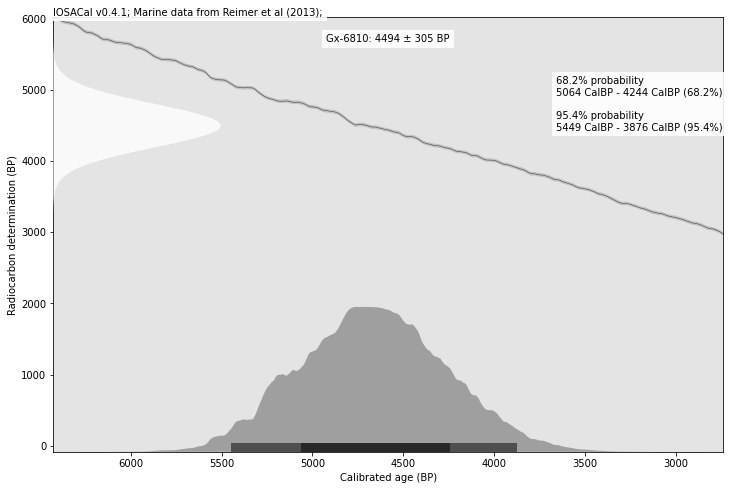

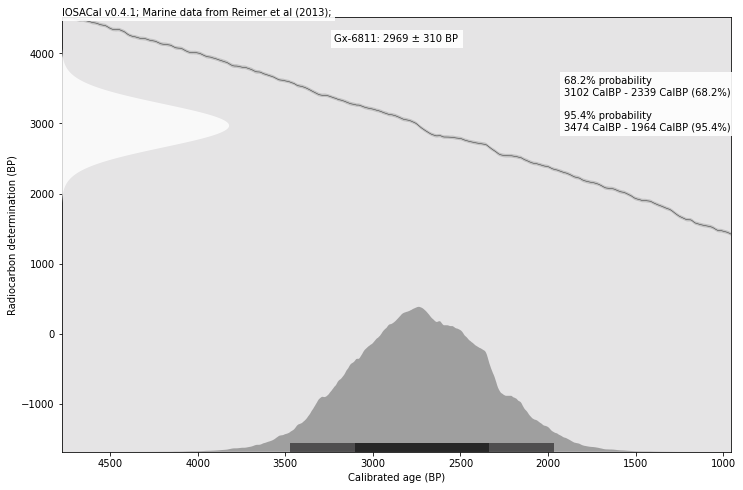

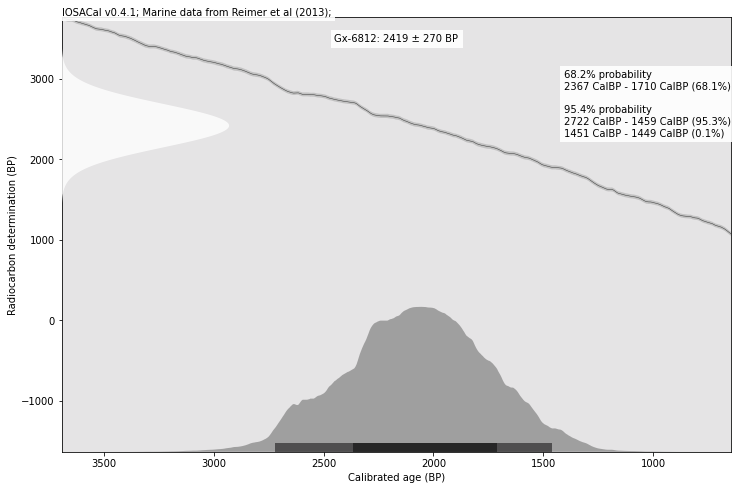

In [9]:
#define the output directory
dir= r"./output/"

#begin for loop iterating through all input records 
for i in range(AppendixA.shape[0]):
    
    #sort date, error, and sample id records and add input radiocarbon sample list
    r = iCal.R(d[i], e[i], s[i])
    
    #calibrate dates with the calibration curve shown in quotes
    cal_r = r.calibrate('marine13')
    
    #create text based output report for radiocarbon calibration
    report = (single_text(cal_r))
    
    #add all integer only words of one of more digits in the report to a list
    findDigits = [int(s) for s in re.findall(r'\b\d+\b', report)]
    
    #append the resulting list values to new lists
    #68% confidence interval values are location 7 and 8
    #95% confidence interval values are location 13 and 14
    cal68.append(findDigits[7:9])
    cal95.append(findDigits[13:15])
    
    #print report for current sample as output
    print(report)
    
    #show probability distribution plot as inline plot below output
    iCal.iplot(cal_r, output = dir + s[i] + ".jpg")

After performing radiocarbon calibration, each output lists is cast to a `numpy array` on `line 2`, `line 3`, `line 4`, and `line 5` to perform the following calculations. 

These values are put into a `for` loop that iterates for `i` number of times on `line 8`. The number of iterations is set to equal `range(AppendixA.shape[0])` once again, allowing the number of iterations to dynamically match the number of samples in the input data.

Within the `for` loop, simple calculations run for 1σ (68%) and 2σ (95%) confidence intervals on `line 11` and `line 12`, and `line 15` and `line 16`, respectively. These calculations retrieving minimum, maximum, mean and uncertainty values for each sample in calibrated years before present (CalBP). Values are then appended to variables `cal95Date`,  `cal95Mean`,  `cal95Err`, `d`, and `e` stored for use in later steps.

In [10]:
#create array objects to hold values not created above
cal68Date = np.array(cal68)
cal95Date = np.array(cal95)
cal95Mean = np.array(d)
cal95Err = np.array(e)

#begin for loop iterating through all input records 
for i in range(AppendixA.shape[0]):
    
    #calculate mean and uncertainty for 68% confidence intervals
    d[i] = (cal68Date[i,0]+cal68Date[i,1])/2
    e[i] = (cal68Date[i,0]-cal68Date[i,1])/2
    
    #calculate mean and uncertainty for 95% confidence intervals
    cal95Mean[i] = (cal95Date[i,0]+cal95Date[i,1])/2
    cal95Err[i] = (cal95Date[i,0]-cal95Date[i,1])/2

A new data frame called `calDates` is created in the following cell. The `calDates` data frame holds our radiocarbon calibration results. 

Aside from the `numpy array` stored in `calMean` on `line 7`, all code in the following cell functions only to prepare data for, and display the new data frame formatted to display the date range, mean, and uncertainty at both confidence intervals for all samples calibrated. These values are shown in the table below, stylized following standard conventions for display of radiocarbon calibration results.

In [11]:
#define columns of radiocarbon calibration table
cols = ['2'+'\u03C3'+' Max Age', '2'+'\u03C3'+' Min Age']
cols2 = ['1'+'\u03C3'+' Max Age', '1'+'\u03C3'+' Min Age']
cols3 = ['2'+'\u03C3'+' Mean Age', '2'+'\u03C3'+' Uncertainty', '1'+'\u03C3'+' Mean Age', '1'+'\u03C3'+' Uncertainty'] 

#create an array holding mean date and uncertainty at each confidence interval
calMean = np.column_stack((cal95Mean,cal95Err,d,e))

#create variable to hold an int of the number of records
numRecs = len(AppendixA)

#load cal95 list to a data frame and add column titles
calDates = pd.DataFrame(cal95)
calDates.columns = cols

#add remaining datasets and column titles
calDates.reindex(columns=calDates.columns.tolist() + cols2)
calDates[cols2] = cal68
calDates.reindex(columns=calDates.columns.tolist() + cols3)
calDates[cols3] = calMean.reshape(numRecs,4)
calDates.insert(0, "Sample ID", AppendixA.iloc[0:numRecs,0])

#stylize and show full results of radiocarbon calibration in a table
calDates.style.hide_index().set_properties([], **{'text-align': 'center'}).format({'2'+'\u03C3'+' Max Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'2'+'\u03C3'+' Min Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'1'+'\u03C3'+' Mean Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'2'+'\u03C3'+' Mean Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'1'+'\u03C3'+' Max Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'1'+'\u03C3'+' Min Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'2'+'\u03C3'+' Uncertainty': lambda x: "±{:.0f} ".format(float(x))}).format({'1'+'\u03C3'+' Uncertainty': lambda x: "±{:.0f} ".format(float(x))}).set_properties(subset=['2'+'\u03C3'+' Uncertainty','1'+'\u03C3'+' Uncertainty'], **{'text-align': 'left'})

Sample ID,2σ Max Age,2σ Min Age,1σ Max Age,1σ Min Age,2σ Mean Age,2σ Uncertainty,1σ Mean Age,1σ Uncertainty
Gx-6810,5449 CalBP,3876 CalBP,5064 CalBP,4244 CalBP,4662 CalBP,±786,4654 CalBP,±410
Gx-6811,3474 CalBP,1964 CalBP,3102 CalBP,2339 CalBP,2719 CalBP,±755,2720 CalBP,±381
Gx-6812,2722 CalBP,1459 CalBP,2367 CalBP,1710 CalBP,2090 CalBP,±631,2038 CalBP,±328


## 4. Calculate *Terminus Ante Quem* Date of Sea Level Proxy Observations

With radiocarbon calibration complete, calculation of the geochronological *terminus ante quem* elevation boundaries can begin. The first calculation will provide the slope of the line connecting each high water elevation-calibrated date coordinate pair in our samples. But first, a data frame called `coordData` is prepared to iteratively perform calculations on.

This table holds the mean value and uncertainty of all calibrated sample dates at both confidence intervals, the calculated higher high water values. A record is appended to the end of the samples list to reference modern higher high water at the study area, Oak Point.

In [12]:
#create list from past hhw values at Oak Point in AppendixA
hhw = list(AppendixA.iloc[0:3,5])
hhw.append(hhwDf.loc[3].at['hhw'])

#define the year today and year of hhw publication
yrToday = datetime.datetime.now().year
yrPub = 2016

#define modern date and errors to append to new data frame
confToday = [[1950-yrPub,0,1950-yrPub,0]]

#create data frame holding mean values
#and errors of calibrated dates for input
#in past sea level calculations
coordData = pd.DataFrame(calMean)

#join the AppendixA table and drop 
#unneccessary columns
coordData = coordData.join(AppendixA)
coordData = coordData.drop(['ID', 'date', 'error','core_depth', 'modern_HHW'], axis=1)

#add a new record for the confidence 
coordData = coordData.append(confToday)

#fill empty values with zeros
coordData = coordData.fillna(0)

#replace zeros with data from hhw list object
coordData.iloc[3:4,4] = coordData.iloc[3:4,4] + float(hhw[3])

#add uncertainty from hhw dataset 
#to modern hhw error
coordData.iloc[3:4,5] = coordData.iloc[3:4,5] + 0.075

#reset the index values dropping old values
coordData = coordData.reset_index(drop=True)

Next, the coordinate pairs are used to calculate slope and intercept of the line connecting samples with sequential dates. Individual coordinates are defined below as `x1`, `x2`, `y1`, and `y2` coordinates. Variable `x1` represents the radiocarbon equivalent date for the year of data publication, 2016, where the value 0 is equal to the year 1950.

We use our coordinate pairs from our table to derive the equation for the linear relationship between the most recent of the radiocarbon dated samples (`Gx-6812`, `HHW_corrected`) and modern HHW for that sample (`Gx-6812`, `modern_HHW`). The equation is later used to solve for the HHW at each of a series of surveyed proxies of past marine limits. At Oak Point, these proxies are  elevations of rooted stumps of a drowned forest exposed during low tide conditions, and an interface of salt marsh peat and former terrestrial sediments.

First, four lists are initialized as `mList`, `bList`, `oldList`, and `yngList` to hold values for slope, y-intercept, elevations from the older dates, and elevations from the younger dates, repectively. The number of iterations of a `while` loop is set to the number of records in `coordData` by storing the length of the index in the variable `iters`. The variable `i` is used to hold the current iteration, and begins at the value `1`. A confidence interval can be selected if necessary with the variable `interval`. In the following we select the 68% confidence interval, but the code is written to accomodate the 95% confidence interval as well.

Within the loop, coordinate data from the `coordData` data frame is stored to the`x1`, `x2`, `y1`, and `y2` variables. The values are sorted into coordinate pairs of date and elevation and held in the list `coords`. A `numpy` `zip()` function is then used to sort `coords` into `x_coords` and `y_coords` lists. The coefficient matrix, `A`, is created from the coordinate lists and used as a parameter for the least squares method, `lstsq()`. Resulting from `lstsq()` are two derived values for slope, `m`, and intercept, `b`, of the equation, printed below.

During each iteration of the loop the values of the coordinate pairs are appended the list objects `mList`, `bList`, `oldList`, and `yngList`. These values are used to provide an estimate of age for each past sea level elevation proxy observation provided in the `geojson` file at `/data/rslPoints.geojson`. 

In [13]:
#create lists for slope, intercept, and
#elevation of older and younger coordinates 
#in each coordinate pair
mList, bList, oldList, yngList = [],[],[],[]

#define number of iterations as equal
#to the number of records input
iters = len(coordData.index)

#set i to 1
i = 1

#selected interval for calculations
#to be completed on
interval = 68

#begin while loop iterating the data
#until the total number of records is reached
while i < iters:

    #if the interval is equal to 95 use 95% C.I., else
    # use 68% C.I. to define x1 and x2 as the dates used
    if interval == 95:
        x1 = coordData.loc[iters-i].at[0]
        x2 = coordData.iloc[iters-i-1,0]
    else:
        x1 = coordData.loc[iters-i].at[2]
        x2 = coordData.loc[iters-i-1].at[2]
        
    #define y1 and y2 as higher high water vales 
    #at the chosen dates
    y1 = coordData.loc[iters-i].at["HHW_corrected"]
    y2 = coordData.loc[iters-i-1].at["HHW_corrected"]
    
    #define the list of coordinate pairs
    coords = [(x1,y1),(x2,y2)]

    #re-arrange the lists then add to an array
    x_coords, y_coords = zip(*coords)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T

    #define variables m and b as the result of least-squares 
    #regression using the input coordinate pairs
    m, b = np.linalg.lstsq(A, y_coords, rcond=None)[0]
    yngList.append(x1)
    oldList.append(x2)
    mList.append(m)
    bList.append(b)

    #print the equation
    print("Equation for {:.0f} to {:.0f} CalBP is y = {:.5f}x + {:.5f}".format(x1,x2,m,b))
    i+=1

Equation for -66 to 2038 CalBP is y = -0.00214x + 6.68584
Equation for 2038 to 2720 CalBP is y = -0.00264x + 7.70589
Equation for 2720 to 4654 CalBP is y = -0.00165x + 5.02752


The following cells provide an overview of the process used to interpolate the date that high water submerged undated sea level proxy observations using surveyed elevations. The cell that follows creates a list value to hold the intepolated dates called `indAge`. A `for` loop iterates through the `mList` and `bList` objects that were filled after correcting HHW elevation. The loop passes input elevation values from the `indElev` list through a set of conditional statements interpolating the value with the correct equation. The interpolated value is then appended the the `indAge` list.

##### Load and solve for date of sea level proxies

The final step in this analysis is to use the elevation of the surveyed sea level indicator points to solve for the year that high water submerged that upland feature.

First a `geojson` file is loaded and the `['features']` of the file are read to the variable `features`. Two empty lists are also created to store indicator elevation, `indElev`, and uncertainty, `zErr` of each input record.

Date values from `coordData` are used to are loaded to the `x` list object, and associated uncertainties at 68% and 95% confidence intervals are stored in `dateErr` and `err95`. The `y` list object holds the corrected high water values from `coordData`, and the uncertainties are held in the list `error`.

The `rslPoints` are then iterated over within a `for` loop. Within the `for` loop three conditions are set to decide which equation to use when solving for date of the indicator. This set number of three `if/else` conditional statements is the one of the only places needing modification if more samples are calibrated within this notebook.

In [14]:
#load geojson file containing surveyed but undated 
#rsl indicator points
with open(r"./data/rslPoints.geojson", 'r') as f:
    data = json.load(f)

#reference geojson feature ID as variable 'features'
features = data['features']
indAge = []
indElev = []
zErr = []

#load x values to plot from the OakPoint data frame  
#then append the modern date relative to 1950
x = list(coordData[2])

#load date uncertainty values to plot from the OakPoint 
#data frame  then append the modern date uncertainty
dateErr = list(coordData[3])
err95 = list(coordData[1])

#load y values to plot from the OakPoint data frame  
#then append the modern high water and uncertainty
y = list(coordData['HHW_corrected'])
error = list(coordData['HHW_error'])

#for each sample decide which equation to solve with
#using corrected elevation of past hhw
for i in range(len(features)):
    if features[i]['properties']['OHeight'] >= y[2]:
        indAge.append((features[i]['properties']['OHeight']-bList[0])/mList[0])
    elif features[i]['properties']['OHeight'] >= y[1]:
        indAge.append((features[i]['properties']['OHeight']-bList[1])/mList[1])
    elif features[i]['properties']['OHeight'] >= y[0]:
        indAge.append((features[i]['properties']['OHeight']-bList[2])/mList[2])

## 5. Visualize Result

An interactive map frame powered by iPyLeaflet is prepared by running the proceeding code block. The map frame is centered on the Oak Point study area at Kingsport marsh.

We define the map frame as *mapFrame* on line 1 followed by adding data and functionality: 

- ESRI satellite imagery basemap
- custom map tile layer from the lidar basemaps shown in the article
- measurement functionality
- full screen functionality
- scale bar
- layer toggle functionality

In [15]:
#initialize map as "mapFrame"
mapFrame = Map(basemap=basemaps.Esri.WorldImagery, center=(45.1562107, -64.3699627), zoom=15, max_zoom=18)

#load and add local tile layer
basemap = LocalTileLayer(name="Shaded Relief",tms = True, attribution="Contains information licensed under the Open Government Licence – Nova Scotia. Created by: Wesley Weatherbee.", path="minasBase/{z}/{x}/{y}.png")
mapFrame.add_layer(basemap)

#load and add measurement function, fullscreen and layer toggle, and a visual scale
measure = MeasureControl(position='topleft',active_color = 'orange',primary_length_unit = 'meters')
mapFrame.add_control(measure)
measure.completed_color = 'red'
mapFrame.add_control(FullScreenControl(position='topright'))
mapFrame.add_control(LayersControl(position='topleft'))
mapFrame.add_control(ScaleControl(position='topright', metric=True))

##### Creation of the map data

The open map above displays datasets that will help explore the output boundaries after running this notebook. The extent of the shaded relief mirrors that of Figure 1 in the associated article presenting a high resolution maximum zoom level of 18 throughout.

The shaded relief layer was created from Lidar derived digital elevation models at 1m resolution from the [Province of Nova Scotia](url: "https://nsgi.novascotia.ca/datalocator/elevation/"). The layer is a series of compressed .png tiles within an organized folder directory using naming conventions relating to geolocation. This directory is located at */minasBase* off of the Binder root folder. 

The */minasBase* directory was automatically created from a Map Tile Package (.tpk) file exported from ArcGIS Pro. With the help of python modules `tpkutils` and `mbutil`, the .tpk was converted to a .mbtiles, MapBox tile package file then extracted to the */minasBase* directory. 

Optimization of the map tiles is responsible for the high zooom level display presented in this Binder. An original file count for the */minasBase* map tiles directory exceeded 5 million, which was not appreciated by GitHub or Binder. However, with the help of native python modules, the file count was reduced to approximately 37000 by removing any .png images in the directory that were a size of 190 bytes or smaller—files of this size contained no image data, only a transparency layer. 

##### Plotting surveyed elevations of sea level proxy observations with calculated dates

Surveyed points have been gathered at Oak Point of a series of past relative sea level proxies. Below we will load and visualize these survey points to the map frame. 

To differentiate the values a `Popup` method is used to visualize the `properties.Code` property of the points when a point is clicked. 

All of the loaded vector data can be found within the `/data` directory, and shaded relief in the `minasBase` directory.

In [16]:
#create variables from hhw csv to plot
#the high water values in the map frame
hhwSmp = pd.read_csv("./data/hhw.csv", usecols=["ID"])
hhwZ = pd.read_csv("./data/hhw.csv", usecols=["hhw"])
hhwCoords = pd.read_csv("./data/hhw.csv", usecols=["lon","lat"])
hhw = hhwSmp.join(hhwZ)

#load geojson files containing digitized
#dyke footing and spit hook
with open(r"./data/dyke.geojson", 'r') as f:
    dyke = json.load(f)
with open(r"./data/spitHook.geojson", 'r') as f:
    hook = json.load(f)

#redefine the list of indicator elevations 
#as an empty list
indElev = []
    
#create layer group referencing json records 
#within the map frame
rslGroup = LayerGroup(name="RSL Indicators", layers=())
hhwGroup = LayerGroup(name="HHW Samples", layers=())

#loop over geojson features
for i in range(len(features)):
    location=(features[i]['geometry']['coordinates'][1],features[i]['geometry']['coordinates'][0])
    indicators = features[i]['properties']['Code']
    indElev.append(features[i]['properties']['OHeight'])
    zErr.append(features[i]['properties']['zError'])
    indA = str(indicators)
    indB = str(features[i]['properties']['OHeight']) + "m CGVD2013"
    indC = str(indAge[i]) + " years CalBP"
    html = """<p><b>Indicator type: </b>""" + f"{indA}" + """<br><b>Elevation: </b>""" + f"{indB}" + """<br><b>Calculated date: </b>""" + f"{indC:.4}" + """ years CalBP</p>"""
    rslPoint = CircleMarker( radius=4, color="#000000", location=location, weight=1, opacity=1, 
                             fill_opacity=0.6, fill_color="#7ecc62", draggable=False)
    
    # Popup associated to a layer
    rslPoint.popup = HTML(html)
    rslGroup.add_layer(rslPoint)

#loop over HHW sample points
for i in range(hhw.shape[0]):
    location = hhwCoords.loc[i].at["lon"],hhwCoords.loc[i].at["lat"]
    descA = str(hhwSmp.loc[i].at["ID"])
    descB = str(hhwZ.loc[i].at["hhw"]) + "m CGVD2013"
    html = """<p><b>ID: </b>""" + f"{descA}" + """<br> <b>Elevation: </b>""" + f"{descB}" + """</p>"""
    hhwPoint = CircleMarker( radius=4, color="#000000", location=location, weight=1, opacity=1, 
                             fill_opacity=0.6, fill_color="#000000", draggable=False)
    # Popup associated to a layer
    hhwPoint.popup = HTML(html)
    hhwGroup.add_layer(hhwPoint)
    
#add dyke layer twice making one line thicker
#creating custom symbology
dykeA = GeoJSON(data=dyke, name="Dyke footing", style={'opacity': 1, 'weight': 1.5, 'color': '#80bfff'})
dykeB = GeoJSON(data=dyke, name="Dyke footing", style={'opacity': 0.6, 'weight': 5, 'color': '#4a75a1'})
symDyke = LayerGroup(name="Dyke footing", layers=(dykeB, dykeA))

#add hook layer twice making one line thicker
#creating custom symbology
hookA = GeoJSON(data=hook, name="Spit hook", style={'opacity': 1, 'weight': 1, 'color': '#FFFF66'})
hookB = GeoJSON(data=hook, name="Spit hook", style={'opacity': 0.5, 'weight': 5, 'color': '#8e8f5d'})
symHook = LayerGroup(name="Spit hook", layers=(hookB, hookA))
                   
#add group layer created from combined rslPoint
#layers
mapFrame.add_layer(symDyke)
mapFrame.add_layer(symHook)
mapFrame.add_layer(rslGroup)
mapFrame.add_layer(hhwGroup)

#call and display the map frame
mapFrame

Map(center=[45.1562107, -64.3699627], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Next, we create a plot of our observations intercepting a relative sea level curve derived from the input data. The plot uses the same custom style as found in the associated article. 

The cell below converts the lists above in to `numpy array` objects, obtains the values from the geojson indicator points we stored in variables previously, and plots the values using custom style parameters.

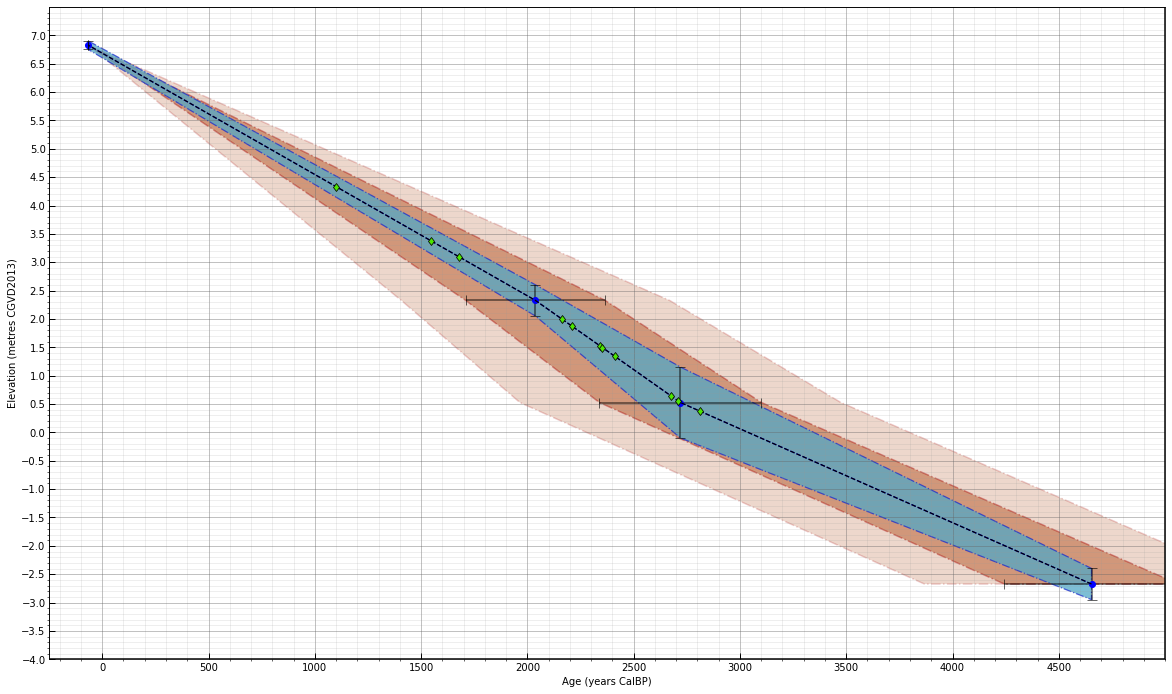

In [17]:
#use the seaborn style colorblind in the plot
plt.style.use('seaborn-colorblind')

#define method to round values to the nearest 5
def myround(x, base=5):
    return int(base * round(float(x)/base))

#define x, y, errors, indicator elevation, z-error, calculated date, and date error
x = np.array(x)
dateErr = np.array(dateErr)
y = np.array(y)
error = np.array(error)
err95 = np.array(err95)
indAge = np.array(indAge)

#plot points, errorbars, interpolated rsl indicator age, and errorbar bounds
plt.plot(x, y, 'bo', x, y, 'k', linewidth=1.25, linestyle='dashed')
plt.plot(indAge, indElev, 'd', color='#4CE600', markersize=6, markeredgewidth=0.75, markeredgecolor='k')
plt.fill_betweenx(y, x-err95, x+err95, alpha=0.2, edgecolor='#A80000', facecolor='#A83800',
    linewidth=1.5, linestyle='dashdot', antialiased=True)
plt.fill_betweenx(y, x-dateErr, x+dateErr, alpha=0.4, edgecolor='#A80000', facecolor='#A83800',
    linewidth=1.5, linestyle='dashdot', antialiased=True)
plt.errorbar(x,y,error,dateErr, alpha=0.6, color='#1B2ACC', linewidth=0, elinewidth=1.5, ecolor='black', capsize=5)
plt.fill_between(x, y-error, y+error, alpha=0.75, edgecolor='#1B2ACC', facecolor='#51A8C7',
    linewidth=1.25, linestyle='dashdot', antialiased=True)

#stylize ticks, gridlines, bounds, and axis labels
plt.xticks(np.arange(0,5000, step=500))
plt.yticks(np.arange(-4,7.5, step=0.5))
plt.axhline(-4,color='black')
plt.axvline(-250,color='black')
plt.axhline(7.5,color='black')
plt.axvline(5000,color='black')
plt.tick_params(direction='in', length=6, width=1, colors='black',grid_color='gray', grid_alpha=0.5)
plt.xlabel('Age (years CalBP)')
plt.ylabel('Elevation (metres CGVD2013)')
plt.xlim(-250, 5000)
plt.ylim(-4, 7.5)

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', alpha=0.2)

#plot the figure and set the size
fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.savefig(r'./output/seaLevelCurve.png', edgecolor='black', dpi=400)

The result of our above plot shows the relative sea-level curve for Oak Point. The calibrated dates were produced with the calibration curve used in the above process, and elevations were corrected using HHW points from a CHS grid surface for higher high water. Uncertainties associated with each point are shown with vertical and horizontal bars.

A linear model is used to show interpolated uncertainty bounds over time. The light red boundary shows uncertainty of the radiocarbon calibration in the 95% confidence interval, while the 68% confidence interval is more opaque. Shown in blue boundary is uncertainty associated with the foram assemblage derived relative sea level indicator points.

There it is. Using the convenience of Jupyter Notebooks, powerful functionality of Python, and accessibility of MyBinder the Supplementary Data has interactively reproduced the analysis required to obtain a *terminus ante quem* proxy date from surveyed observations of coastal archaeological sites and landscapes.